<a href="https://colab.research.google.com/github/saw9090/FDA/blob/main/NLFFR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import rbf_kernel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## useful functions

In [3]:
# kernel 함수 정의
def GRB(x,y,gamma):
  return np.exp(-gamma*(x-y)**2)

In [4]:
# kernel matrix 정의
def kernel_matrix(grid,gamma_T = 1,kernel = GRB) :
  grid = np.linspace(0, 1, 51)
  n = len(grid)
  kernel_matrix = np.zeros((n,n))
  for i in range(n) :
      for j in range(i,n) :
        kernel_matrix[i,j] = kernel(grid[i],grid[j],gamma_T)
  kernel_matrix += kernel_matrix.T - np.diag(np.diag(kernel_matrix))
  return kernel_matrix

In [112]:
# H_X 내의 inner product 정의
def inner_product_H_X(X_i, X_j,grid,gamma_T = 0.1,epsilon_T = 0.01) :
  K_T = kernel_matrix(grid=grid,gamma_T = gamma_T)
  if (len(grid) != len(X_i)) :
    raise ValueError("The shapes of grid and X_i are different")
  n = len(grid)
  result = X_i.reshape(1,-1) @ np.linalg.inv(K_T + epsilon_T *np.eye(n)) @ K_T @ np.linalg.inv(K_T + epsilon_T *np.eye(n)) @ X_j.reshape(-1,1)
  return result.item()

In [74]:
# H_X 내의 inner product 정의
def inner_product_H_X(X_i, X_j,grid,gamma_T = 0.1,epsilon_T = 0.01) :
  K_T = kernel_matrix(grid=grid,gamma_T = gamma_T)
  if (len(grid) != len(X_i)) :
    raise ValueError("The shapes of grid and X_i are different")
  n = len(grid)
  result = X_i.reshape(1,-1) @ K_T @ X_j.reshape(-1,1)
  return result.item()

In [6]:
def norm_square(x,grid) :
  return inner_product_H_X(x,x,grid)

In [73]:
def RKHS_kernel(x,y,grid,gamma_X) :
  return np.exp(-gamma_X*norm_square(x-y,grid))

In [8]:
def RKHS_kernel_matrix(X,grid, gamma_X=1):
    n = X.shape[1]
    kernel_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            kernel_matrix[i, j] = RKHS_kernel(X[:, i], X[:, j],grid, gamma_X=gamma_X)
    kernel_matrix += kernel_matrix.T - np.diag(np.diag(kernel_matrix))
    return kernel_matrix

In [93]:
def d(x,grid,gamma_X) :
  d_x = np.zeros(N)
  for i in range(N) :
    d_x[i] = RKHS_kernel(X[:,i],x,grid,gamma_X) - np.mean(K_X[i,:])
  return d_x

## model1_dense design

In [41]:
# X generating 함수 정의
def data_generate(gamma,n=100,kernel = GRB) :
  X = np.zeros((51,n))
  for i in range(n) :
    t = np.random.uniform(size = 5)
    a = np.random.normal(size = 5)
    grid = np.linspace(0, 1, 51)
    matrix = np.zeros((51,5))
    for j in range(51) :
      for k in range(5) :
        matrix[j,k] = kernel(grid[j],t[k],gamma)
    X[:,i] = matrix @ a
  return X

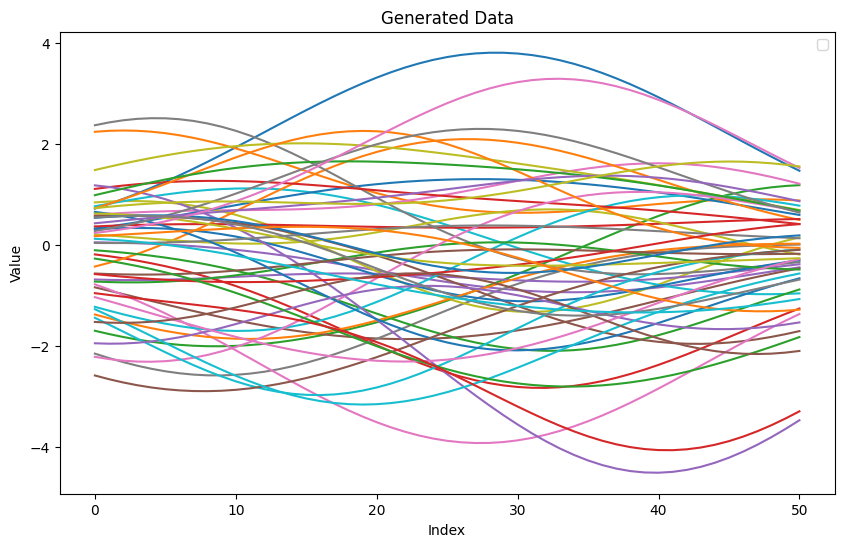

In [113]:
# X 생성 및 개형
np.random.seed(0)
N=50
X = data_generate(gamma=7, n=N)

plt.figure(figsize=(10, 6))
for i in range(X.shape[1]):
    plt.plot(X[:, i])

plt.title('Generated Data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [114]:
# rho 정의
def rho(t) :
  rho = 0
  np.random.seed(0)
  a = np.random.normal(size = 5)
  for i in range(5):
    rho += np.sqrt(2) * a[i] * np.sin((i+1/2)* np.pi * t)
  return rho

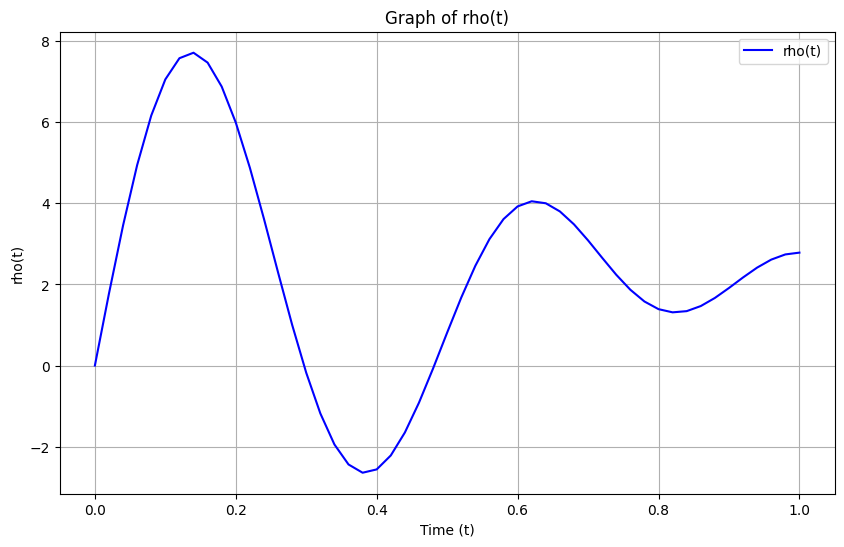

In [115]:
# rho 개형
t = np.linspace(0, 1, 51)
rho_values = [rho(ti) for ti in t]

plt.figure(figsize=(10, 6))
plt.plot(t, rho_values, label='rho(t)', color='b')
plt.xlabel('Time (t)')
plt.ylabel('rho(t)')
plt.title('Graph of rho(t)')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
# brownian motion 정의
def brownian_motion(T, N):
    dt = T / float(N)
    t = np.linspace(0, T, N+1)
    W = np.zeros(N+1)

    for i in range(1, N+1):
        dW = np.sqrt(dt) * np.random.normal(0, 1)
        W[i] = W[i-1] + dW

    return t, W

In [117]:
# 모델 정의
def b1(t,kernel = GRB,gamma = 1) :
  return kernel(t,0.6,gamma=gamma)
def b2(t,kernel = GRB,gamma = 1) :
  return kernel(t,0.9,gamma=gamma)
def b3(t,kernel = GRB,gamma = 1) :
  return kernel(t,0.1,gamma=gamma)

def model1(X,gamma = 1, sigma = 0.1):
  grid_X = np.linspace(0, 1, 51)
  grid_y = np.linspace(0, 1, 51)
  b1_t = b1(grid_X)
  b2_t = b2(grid_X)
  rho_t = rho(grid_y)
  _,brownian_t =  brownian_motion(1,50)
  inner_1 = inner_product_H_X(X,b1_t,grid = grid_X,gamma_T = gamma)
  inner_2 = inner_product_H_X(X,b2_t,grid = grid_X,gamma_T = gamma)
  y= (1/(np.exp(inner_1) + 1) + inner_2**2) * rho_t + sigma * brownian_t
  return y

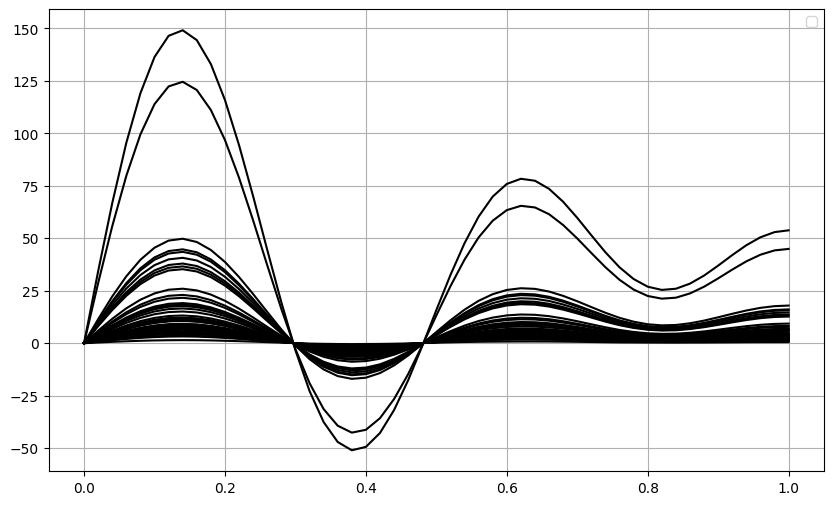

In [118]:
# Y 생성 및 개형
grid_x = np.linspace(0, 1, 51)
grid_y = np.linspace(0, 1, 51)
y = np.zeros((len(grid_y), X.shape[1]))
for n in range(X.shape[1]):
  y[:,n] = model1(X[:,n])
plt.figure(figsize=(10, 6))
for n in range(y.shape[1]):
  plt.plot(grid_y, y[:,n], color='black')
plt.legend()
plt.grid(True)
plt.show()

In [130]:
X_test = data_generate(gamma=7, n=3)
y_test = np.zeros((len(grid_y), X_test.shape[1]))
for n in range(X_test.shape[1]):
  y_test[:,n] = model1(X_test[:,n])

In [120]:
y_test.shape

(51, 2)

In [121]:
Q = np.eye(N) - np.ones((N,N))/N

In [122]:
from sklearn.model_selection import ParameterGrid
import numpy as np

param_grid = {
    'epsilon_X': [0.01,0.001,0.0001],
    'gamma_X': [1,0.1,0.01,0.001]
}
grid = np.linspace(0, 1, 51)
best_gcv = float('inf')
best_params = None

# Grid search
for params in ParameterGrid(param_grid):
    epsilon_X = params['epsilon_X']
    gamma_X = params['gamma_X']
    GCV = 0
    K_X = RKHS_kernel_matrix(X,grid,gamma_X=gamma_X)
    G_X = Q @ K_X @ Q
    for i in range(N) :
      y_pred = (y@(np.linalg.inv(G_X + epsilon_X *np.eye(N)) @ G_X @ Q[:,i] +1/N).reshape(-1,1)).flatten()
      GCV += norm_square(y_pred-y[:,i],grid)/(1-np.trace(Q @ G_X @ np.linalg.inv(G_X + epsilon_X *np.eye(N)) + np.ones((N,N))/N)/N)**2
    GCV /= N
    if GCV < best_gcv:
        best_gcv = GCV
        best_params = params

print(f"Best GCV: {best_gcv}")
print(f"Best Parameters: {best_params}")


Best GCV: 371.6869408796029
Best Parameters: {'epsilon_X': 0.0001, 'gamma_X': 0.01}


In [123]:
epsilon_X = best_params['epsilon_X']
gamma_X = best_params['gamma_X']

In [124]:
K_X = RKHS_kernel_matrix(X,grid,gamma_X=gamma_X)
G_X = Q @ K_X @ Q

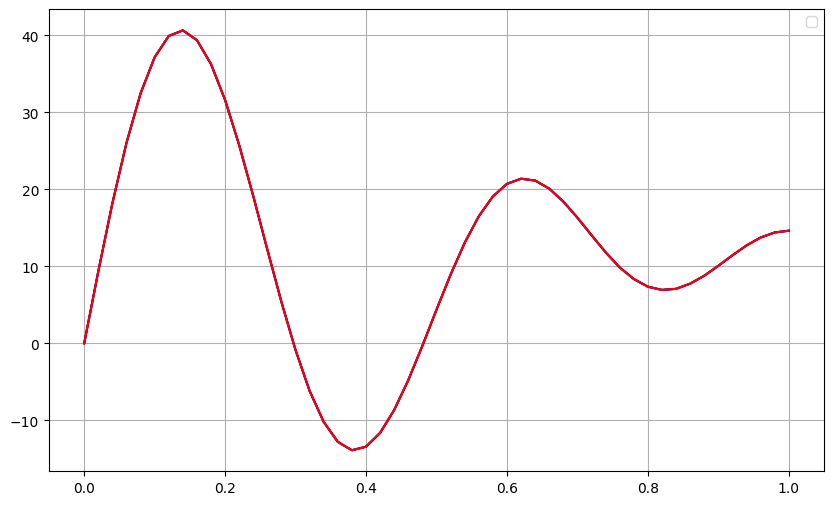

In [125]:
#(X1,Y1)
y_pred1 = y @ (G_X @ np.linalg.inv(G_X + epsilon_X *np.eye(N)) @ Q @ np.linalg.inv(K_X + epsilon_X *np.eye(N))) @ d(X[:,0],grid,gamma_X) + np.mean(y,axis=1)
y_pred2 = (y@(np.linalg.inv(G_X + epsilon_X *np.eye(N)) @ G_X @ Q[:,0] +1/N).reshape(-1,1)).flatten()
grid_y = np.linspace(0, 1, 51)

plt.figure(figsize=(10, 6))
plt.plot(grid_y, y[:,0], color='black')
plt.plot(grid_y, y_pred1, color='blue')
plt.plot(grid_y, y_pred2, color='red')
plt.legend()
plt.grid(True)
plt.show()

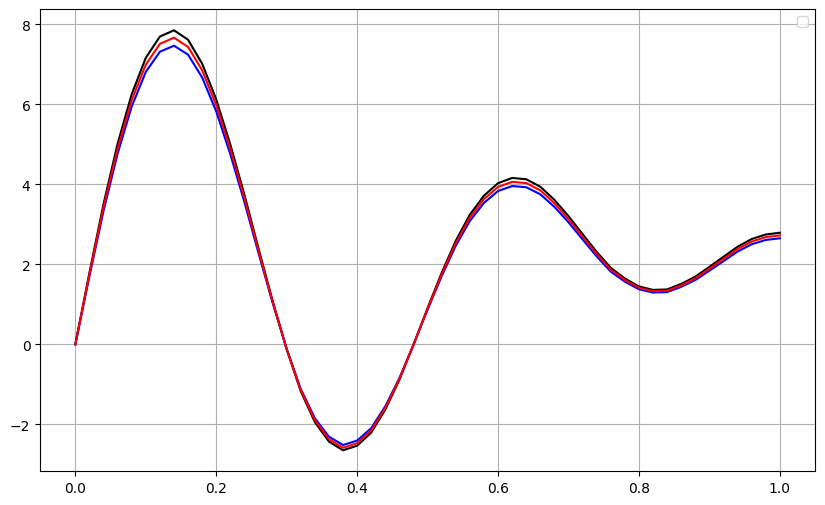

In [126]:
#(X2,Y2)
y_pred1 = y @ (G_X @ np.linalg.inv(G_X + epsilon_X *np.eye(N)) @ Q @ np.linalg.inv(K_X + epsilon_X *np.eye(N))) @ d(X[:,1],grid,gamma_X) + np.mean(y,axis=1)
y_pred2 = (y@(np.linalg.inv(G_X + epsilon_X *np.eye(N)) @ G_X @ Q[:,1] +1/N).reshape(-1,1)).flatten()
grid_y = np.linspace(0, 1, 51)

plt.figure(figsize=(10, 6))
plt.plot(grid_y, y[:,1], color='black')
plt.plot(grid_y, y_pred1, color='blue')
plt.plot(grid_y, y_pred2, color='red')
plt.legend()
plt.grid(True)
plt.show()

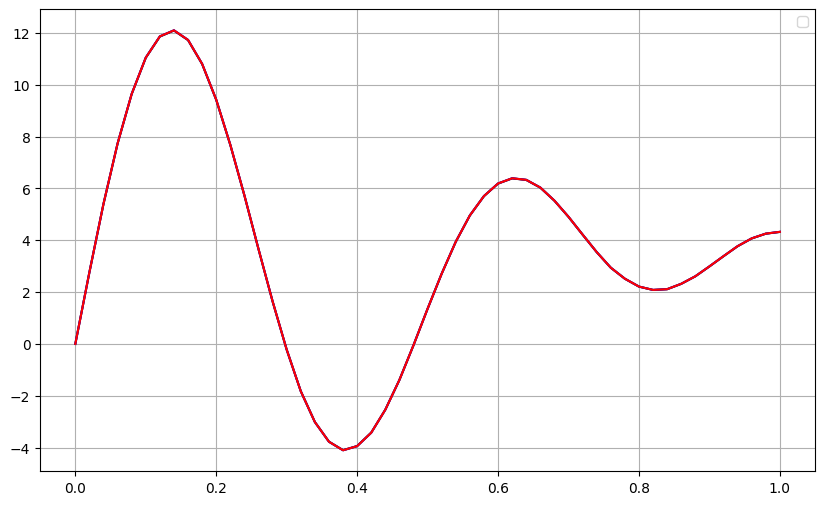

In [127]:
#(X3,Y3)
y_pred1 = y @ (G_X @ np.linalg.inv(G_X + epsilon_X *np.eye(N)) @ Q @ np.linalg.inv(K_X + epsilon_X *np.eye(N))) @ d(X[:,2],grid,gamma_X) + np.mean(y,axis=1)
y_pred2 = (y@(np.linalg.inv(G_X + epsilon_X *np.eye(N)) @ G_X @ Q[:,2] +1/N).reshape(-1,1)).flatten()
grid_y = np.linspace(0, 1, 51)

plt.figure(figsize=(10, 6))
plt.plot(grid_y, y[:,2], color='black')
plt.plot(grid_y, y_pred1, color='blue')
plt.plot(grid_y, y_pred2, color='red')
plt.legend()
plt.grid(True)
plt.show()

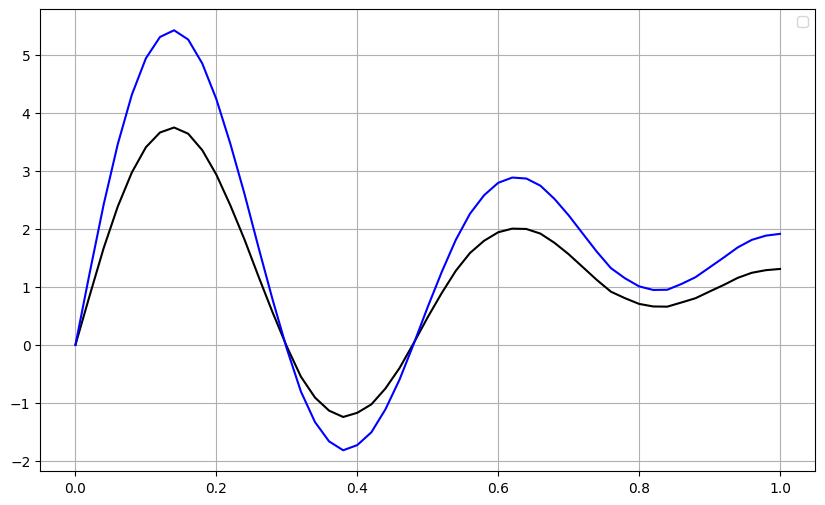

In [128]:
# test(X1,Y1)
y_pred = y @ (G_X @ np.linalg.inv(G_X + epsilon_X *np.eye(N)) @ Q @ np.linalg.inv(K_X + epsilon_X *np.eye(N))) @ d(X_test[:,0],grid,gamma_X) + np.mean(y,axis=1)
grid_y = np.linspace(0, 1, 51)

plt.figure(figsize=(10, 6))
plt.plot(grid_y, y_test[:,0], color='black')
plt.plot(grid_y, y_pred, color='blue')
plt.legend()
plt.grid(True)
plt.show()

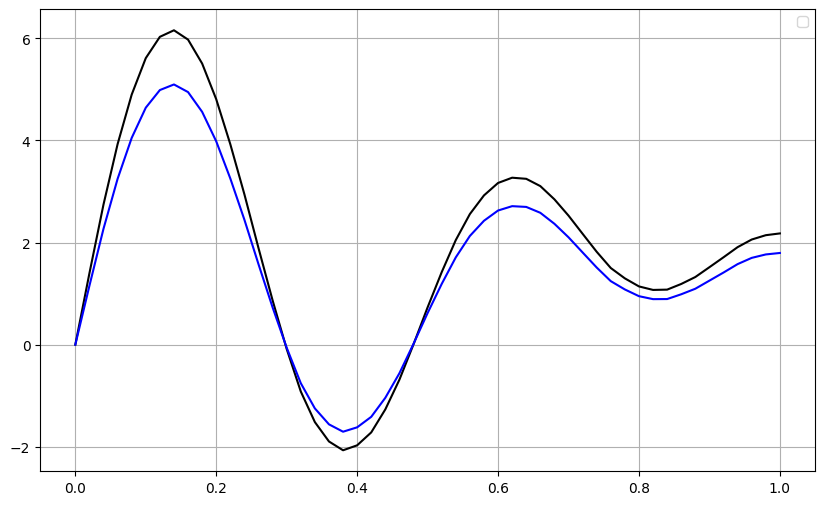

In [129]:
# test(X2,Y2)
y_pred = y @ (G_X @ np.linalg.inv(G_X + epsilon_X *np.eye(N)) @ Q @ np.linalg.inv(K_X + epsilon_X *np.eye(N))) @ d(X_test[:,1],grid,gamma_X) + np.mean(y,axis=1)
grid_y = np.linspace(0, 1, 51)

plt.figure(figsize=(10, 6))
plt.plot(grid_y, y_test[:,1], color='black')
plt.plot(grid_y, y_pred, color='blue')
plt.legend()
plt.grid(True)
plt.show()

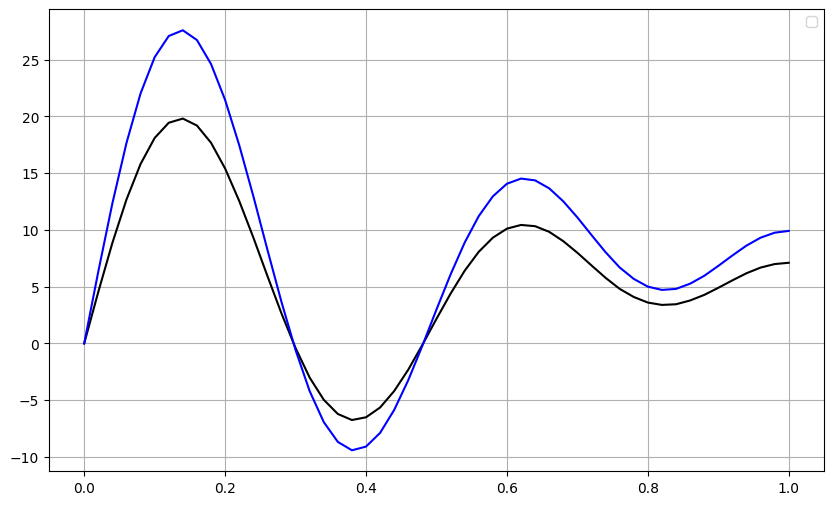

In [131]:
# test(X3,Y3)
y_pred = y @ (G_X @ np.linalg.inv(G_X + epsilon_X *np.eye(N)) @ Q @ np.linalg.inv(K_X + epsilon_X *np.eye(N))) @ d(X_test[:,2],grid,gamma_X) + np.mean(y,axis=1)
grid_y = np.linspace(0, 1, 51)

plt.figure(figsize=(10, 6))
plt.plot(grid_y, y_test[:,2], color='black')
plt.plot(grid_y, y_pred, color='blue')
plt.legend()
plt.grid(True)
plt.show()

In [72]:
RKHS_kernel(X[:,0],X_test[:,0],grid)

6.64385690841657e-250